## Load Dataset

In [17]:
import pandas as pd

df = pd.read_csv(r'.\dataset\PRICE.csv')

import datetime as dt
def GetWeekDate(year, week):
    d = "{}-W{}".format(year, week)
    r = dt.datetime.strptime(d + '-0', "%Y-W%W-%w")
    return r

df['date'] = df[['YEAR','WEEK']].apply(lambda x : GetWeekDate(x[0],x[1]), axis=1)

df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['SKU', 'date'], inplace=True)

df.set_index('date', inplace=True)

df = df.fillna(method="ffill")

df.drop(columns=['YEAR'], axis=1, inplace=True)

df1=df.copy()

In [18]:
from pandas import read_csv
from datetime import datetime
df.drop(['SALES AMOUNT'], 1, inplace=True)
cols=['UNITS']
cols.extend([c for c in df.columns if c not in ['UNITS']])
print(cols)
df = df[cols]
df.to_csv('pricing.csv')

['UNITS', 'CATEGORY', 'SKU', 'WEEK', 'SYSTEM PRICE', "Competitor's price", 'NetCost', 'REAL PRICE', 'MIN TEMP', 'AVG TEMP', 'MAX TEMP', 'RAIN INTENSITY', 'PROMOTION']


## Data exploration

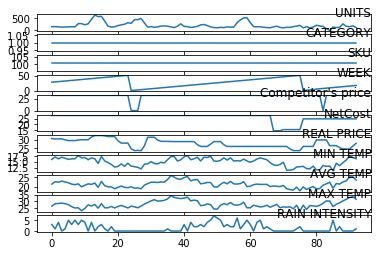

In [19]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pricing.csv', header=0, index_col=0)
dataset=dataset[(dataset['SKU']==101)]
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()
pyplot.show()

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

pd.set_option('display.float_format', lambda x: '%.3f' % x)
per_feat = select_kbest_reg(df, 'UNITS', 5)
per_feat = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
print("\n Feature Score using regression\n")

from tabulate import tabulate
print(tabulate(per_feat, headers='keys', tablefmt='pipe'))


 Feature Score using regression

|    |    F Score |      P Value | Support   | Attribute          |
|---:|-----------:|-------------:|:----------|:-------------------|
| 11 | 6097.77    | 0            | True      | PROMOTION          |
|  3 | 4883.87    | 0            | True      | SYSTEM PRICE       |
|  6 | 4234.03    | 0            | True      | REAL PRICE         |
|  5 | 3680.61    | 0            | True      | NetCost            |
|  4 | 2047.72    | 0            | True      | Competitor's price |
|  1 | 1675.34    | 0            | False     | SKU                |
|  0 |  777.626   | 2.68519e-170 | False     | CATEGORY           |
|  2 |   60.0118  | 9.54124e-15  | False     | WEEK               |
|  7 |   46.0613  | 1.15421e-11  | False     | MIN TEMP           |
|  8 |    3.62565 | 0.056899     | False     | AVG TEMP           |
| 10 |    2.6292  | 0.104919     | False     | RAIN INTENSITY     |
|  9 |    1.78562 | 0.181465     | False     | MAX TEMP           |


## Data preprocessing

In [21]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def scale_values(input_var):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(input_var)
    print(scaled.shape)
    if isinstance(input_var, pd.DataFrame):
        result=DataFrame(scaled, columns=input_var.columns)
    else:
        result=scaled
    return scaler, result
 
# load dataset
dataset = read_csv('pricing.csv', header=0, index_col=0)
print(dataset.columns)
values = dataset.values

timesteps = 2
n_features = len(dataset.columns)

# ensure all data is float
values = values.astype('float64')
scaler,values = scale_values(values)
print(values.shape)

i=0
for sku in np.unique(values[:,2]):
    new_values=values[values[:,2]==sku,:]
    # frame as supervised learning
    reframed = series_to_supervised(new_values, timesteps, 1)
    if(i==0):
        new_reframed=reframed
    else:
        new_reframed = pd.concat([new_reframed,reframed], axis=0)
    i=i+1
print(i)
reframed=new_reframed
# drop columns we don't want to predict
#drop_columns=[c for c in reframed.columns if c not in ['var1(t)'] and c.find("(t)")!=-1]
#print(drop_columns)
#reframed.drop(drop_columns, axis=1, inplace=True)

cols=[c for c in reframed.columns if c not in ['var1(t)']]
cols.extend(['var1(t)'])
print(cols)
reframed = reframed[cols]

print(reframed.shape)
print(reframed.head())

Index(['UNITS', 'CATEGORY', 'SKU', 'WEEK', 'SYSTEM PRICE',
       'Competitor's price', 'NetCost', 'REAL PRICE', 'MIN TEMP', 'AVG TEMP',
       'MAX TEMP', 'RAIN INTENSITY', 'PROMOTION'],
      dtype='object')
(78578, 13)
(78578, 13)
1030
['var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var1(t)']
(76519, 39)
   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2      0.006      0.000      0.000      0.549      0.202      0.296   
3      0.006      0.000      0.000      0.569      0.219      0.296   
4      0.006      0.000      0.000      0.

In [22]:
import numpy as np

#train_X, train_y=reframed.as_matrix()[:,:-1], reframed.as_matrix()[:,-1]
#print(train_X.shape, train_y.shape)
#train_X = train_X.reshape((train_X.shape[0], timesteps*n_features))
#train_y = train_y.reshape((len(train_y), 1))
#inv_y = concatenate((train_y, train_X[:,:-1]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#print(inv_y[0])

#np.random.seed(1)
#np.random.shuffle(values)

# split into train and test sets
values = reframed.values
n_train_hours = int(np.ceil(len(values)*4/5))
print(n_train_hours)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

61216
(61216, 38) 61216 (61216,)
(61216, 1, 38) (61216,) (15303, 1, 38) (15303,)


## Experiments and Results

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 11s - loss: 0.0062 - mean_squared_error: 2.0335e-04 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 18428.6353 - cosine_proximity: -8.3123e-01 - mean_squared_logarithmic_error: 1.5653e-04 - val_loss: 0.0069 - val_mean_squared_error: 1.6576e-04 - val_mean_absolute_error: 0.0069 - val_mean_absolute_percentage_error: 22374.9376 - val_cosine_proximity: -3.1667e-01 - val_mean_squared_logarithmic_error: 1.2010e-04
Epoch 2/50
 - 6s - loss: 0.0039 - mean_squared_error: 1.1435e-04 - mean_absolute_error: 0.0039 - mean_absolute_percentage_error: 10021.7150 - cosine_proximity: -8.6480e-01 - mean_squared_logarithmic_error: 8.7918e-05 - val_loss: 0.0053 - val_mean_squared_error: 1.3957e-04 - val_mean_absolute_error: 0.0053 - val_mean_absolute_percentage_error: 16766.1687 - val_cosine_proximity: -5.0635e-01 - val_mean_squared_logarithmic_error: 1.0162e-04
Epoch 3/50
 - 6s - loss: 0.0037 - mean_squared_error: 1.0695e-04 - 

Epoch 20/50
 - 7s - loss: 0.0030 - mean_squared_error: 8.3013e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 5752.3985 - cosine_proximity: -9.2366e-01 - mean_squared_logarithmic_error: 6.3715e-05 - val_loss: 0.0059 - val_mean_squared_error: 1.1940e-04 - val_mean_absolute_error: 0.0059 - val_mean_absolute_percentage_error: 24107.2308 - val_cosine_proximity: -9.9398e-01 - val_mean_squared_logarithmic_error: 9.1943e-05
Epoch 21/50
 - 7s - loss: 0.0030 - mean_squared_error: 8.2872e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 5944.7599 - cosine_proximity: -9.1646e-01 - mean_squared_logarithmic_error: 6.3702e-05 - val_loss: 0.0051 - val_mean_squared_error: 1.1094e-04 - val_mean_absolute_error: 0.0051 - val_mean_absolute_percentage_error: 19280.5619 - val_cosine_proximity: -9.9374e-01 - val_mean_squared_logarithmic_error: 8.3731e-05
Epoch 22/50
 - 7s - loss: 0.0029 - mean_squared_error: 8.1624e-05 - mean_absolute_error: 0.0029 - mean_absolute_percen

Epoch 39/50
 - 7s - loss: 0.0027 - mean_squared_error: 6.9846e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6392.6978 - cosine_proximity: -9.2238e-01 - mean_squared_logarithmic_error: 5.3822e-05 - val_loss: 0.0036 - val_mean_squared_error: 9.2418e-05 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 10660.0886 - val_cosine_proximity: -9.8939e-01 - val_mean_squared_logarithmic_error: 6.6012e-05
Epoch 40/50
 - 7s - loss: 0.0027 - mean_squared_error: 6.9094e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6099.7425 - cosine_proximity: -9.2992e-01 - mean_squared_logarithmic_error: 5.3215e-05 - val_loss: 0.0036 - val_mean_squared_error: 9.2782e-05 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 10329.8437 - val_cosine_proximity: -9.8915e-01 - val_mean_squared_logarithmic_error: 6.6179e-05
Epoch 41/50
 - 7s - loss: 0.0027 - mean_squared_error: 6.8970e-05 - mean_absolute_error: 0.0027 - mean_absolute_percen

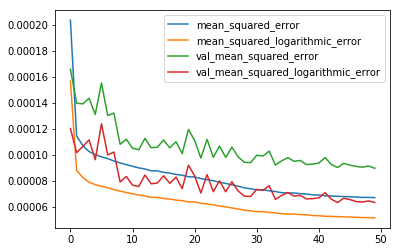

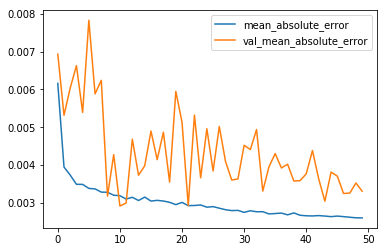

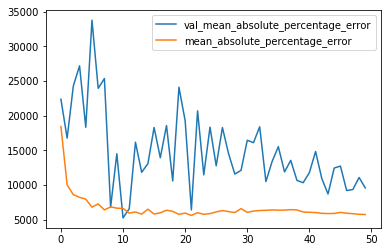

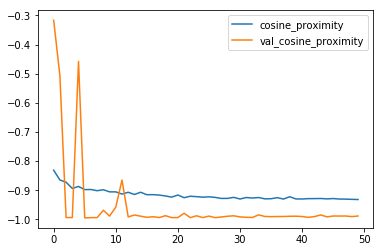

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 7s - loss: 0.0057 - mean_squared_error: 1.9464e-04 - mean_absolute_error: 0.0057 - mean_absolute_percentage_error: 17146.5154 - cosine_proximity: -8.3908e-01 - mean_squared_logarithmic_error: 1.4608e-04 - val_loss: 0.0036 - val_mean_squared_error: 1.2275e-04 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 7523.5499 - val_cosine_proximity: -8.5609e-01 - val_mean_squared_logarithmic_error: 9.1253e-05
Epoch 2/50
 - 6s - loss: 0.0038 - mean_squared_error: 1.1890e-04 - mean_absolute_error: 0.0038 - mean_absolute_percentage_error: 9307.8475 - cosine_proximity: -8.7490e-01 - mean_squared_logarithmic_error: 8.9805e-05 - val_loss: 0.0055 - val_mean_squared_error: 1.2714e-04 - val_mean_absolute_error: 0.0055 - val_mean_absolute_percentage_error: 18176.6741 - val_cosine_proximity: -9.9208e-01 - val_mean_squared_logarithmic_error: 9.8615e-05
Epoch 3/50
 - 6s - loss: 0.0036 - mean_squared_error: 1.1230e-04 - mea

Epoch 20/50
 - 7s - loss: 0.0030 - mean_squared_error: 9.0191e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6464.7353 - cosine_proximity: -9.1940e-01 - mean_squared_logarithmic_error: 6.7964e-05 - val_loss: 0.0031 - val_mean_squared_error: 8.3385e-05 - val_mean_absolute_error: 0.0031 - val_mean_absolute_percentage_error: 5640.4413 - val_cosine_proximity: -9.8661e-01 - val_mean_squared_logarithmic_error: 6.3313e-05
Epoch 21/50
 - 7s - loss: 0.0029 - mean_squared_error: 8.9527e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 5798.2280 - cosine_proximity: -9.2713e-01 - mean_squared_logarithmic_error: 6.7392e-05 - val_loss: 0.0033 - val_mean_squared_error: 8.3751e-05 - val_mean_absolute_error: 0.0033 - val_mean_absolute_percentage_error: 7609.7374 - val_cosine_proximity: -7.8111e-01 - val_mean_squared_logarithmic_error: 6.3424e-05
Epoch 22/50
 - 6s - loss: 0.0029 - mean_squared_error: 8.8689e-05 - mean_absolute_error: 0.0029 - mean_absolute_percenta

Epoch 39/50
 - 8s - loss: 0.0027 - mean_squared_error: 7.8767e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6544.0856 - cosine_proximity: -9.2810e-01 - mean_squared_logarithmic_error: 5.9000e-05 - val_loss: 0.0036 - val_mean_squared_error: 7.3472e-05 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 9368.7618 - val_cosine_proximity: -9.9382e-01 - val_mean_squared_logarithmic_error: 5.6014e-05
Epoch 40/50
 - 8s - loss: 0.0027 - mean_squared_error: 7.8148e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6373.9039 - cosine_proximity: -9.3103e-01 - mean_squared_logarithmic_error: 5.8496e-05 - val_loss: 0.0033 - val_mean_squared_error: 7.2291e-05 - val_mean_absolute_error: 0.0033 - val_mean_absolute_percentage_error: 7397.3233 - val_cosine_proximity: -9.9153e-01 - val_mean_squared_logarithmic_error: 5.4774e-05
Epoch 41/50
 - 7s - loss: 0.0027 - mean_squared_error: 7.7832e-05 - mean_absolute_error: 0.0027 - mean_absolute_percenta

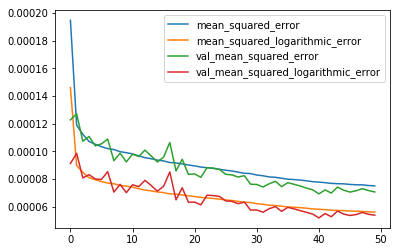

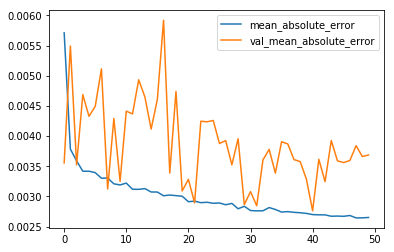

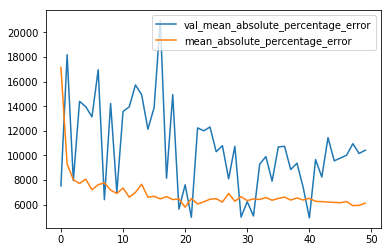

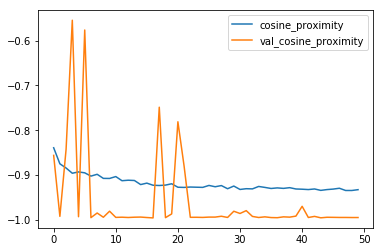

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 7s - loss: 0.0060 - mean_squared_error: 2.1277e-04 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 18864.0650 - cosine_proximity: -8.3683e-01 - mean_squared_logarithmic_error: 1.6022e-04 - val_loss: 0.0088 - val_mean_squared_error: 1.6448e-04 - val_mean_absolute_error: 0.0088 - val_mean_absolute_percentage_error: 31923.2275 - val_cosine_proximity: -9.9525e-01 - val_mean_squared_logarithmic_error: 1.3800e-04
Epoch 2/50
 - 6s - loss: 0.0039 - mean_squared_error: 1.3012e-04 - mean_absolute_error: 0.0039 - mean_absolute_percentage_error: 10178.1811 - cosine_proximity: -8.7152e-01 - mean_squared_logarithmic_error: 9.6731e-05 - val_loss: 0.0037 - val_mean_squared_error: 1.0085e-04 - val_mean_absolute_error: 0.0037 - val_mean_absolute_percentage_error: 8144.1988 - val_cosine_proximity: -9.7010e-01 - val_mean_squared_logarithmic_error: 7.8026e-05
Epoch 3/50
 - 6s - loss: 0.0035 - mean_squared_error: 1.1970e-04 - me

Epoch 20/50
 - 7s - loss: 0.0029 - mean_squared_error: 9.0534e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 6231.1470 - cosine_proximity: -9.2413e-01 - mean_squared_logarithmic_error: 6.8007e-05 - val_loss: 0.0046 - val_mean_squared_error: 8.3613e-05 - val_mean_absolute_error: 0.0046 - val_mean_absolute_percentage_error: 13398.2550 - val_cosine_proximity: -9.9269e-01 - val_mean_squared_logarithmic_error: 6.5649e-05
Epoch 21/50
 - 6s - loss: 0.0029 - mean_squared_error: 8.9682e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 6828.3959 - cosine_proximity: -9.2174e-01 - mean_squared_logarithmic_error: 6.7383e-05 - val_loss: 0.0047 - val_mean_squared_error: 8.4300e-05 - val_mean_absolute_error: 0.0047 - val_mean_absolute_percentage_error: 13927.4498 - val_cosine_proximity: -9.9200e-01 - val_mean_squared_logarithmic_error: 6.6371e-05
Epoch 22/50
 - 6s - loss: 0.0029 - mean_squared_error: 8.8796e-05 - mean_absolute_error: 0.0029 - mean_absolute_percen

Epoch 39/50
 - 6s - loss: 0.0027 - mean_squared_error: 7.8186e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6831.1347 - cosine_proximity: -9.2963e-01 - mean_squared_logarithmic_error: 5.8685e-05 - val_loss: 0.0028 - val_mean_squared_error: 6.9407e-05 - val_mean_absolute_error: 0.0028 - val_mean_absolute_percentage_error: 5973.9252 - val_cosine_proximity: -9.7545e-01 - val_mean_squared_logarithmic_error: 5.1642e-05
Epoch 40/50
 - 7s - loss: 0.0027 - mean_squared_error: 7.7438e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6697.1131 - cosine_proximity: -9.3413e-01 - mean_squared_logarithmic_error: 5.8113e-05 - val_loss: 0.0032 - val_mean_squared_error: 7.0779e-05 - val_mean_absolute_error: 0.0032 - val_mean_absolute_percentage_error: 7383.4489 - val_cosine_proximity: -9.8321e-01 - val_mean_squared_logarithmic_error: 5.2743e-05
Epoch 41/50
 - 7s - loss: 0.0027 - mean_squared_error: 7.7183e-05 - mean_absolute_error: 0.0027 - mean_absolute_percenta

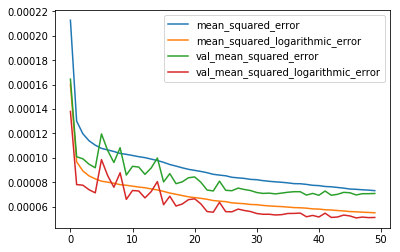

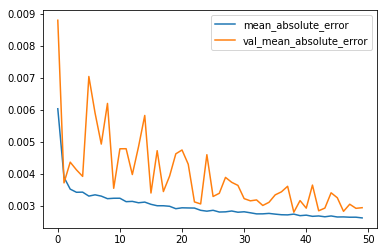

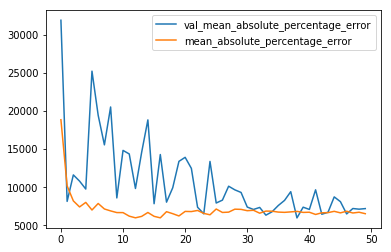

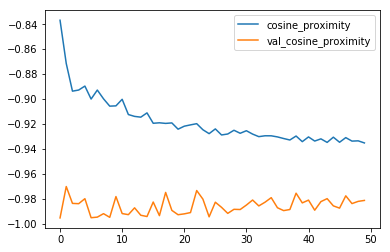

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 7s - loss: 0.0059 - mean_squared_error: 2.1745e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 17402.9183 - cosine_proximity: -8.3183e-01 - mean_squared_logarithmic_error: 1.6144e-04 - val_loss: 0.0041 - val_mean_squared_error: 1.1549e-04 - val_mean_absolute_error: 0.0041 - val_mean_absolute_percentage_error: 10374.7222 - val_cosine_proximity: -7.2797e-01 - val_mean_squared_logarithmic_error: 8.8312e-05
Epoch 2/50
 - 6s - loss: 0.0040 - mean_squared_error: 1.2643e-04 - mean_absolute_error: 0.0040 - mean_absolute_percentage_error: 9984.8073 - cosine_proximity: -8.6449e-01 - mean_squared_logarithmic_error: 9.4072e-05 - val_loss: 0.0042 - val_mean_squared_error: 1.0841e-04 - val_mean_absolute_error: 0.0042 - val_mean_absolute_percentage_error: 10947.3754 - val_cosine_proximity: -6.6470e-01 - val_mean_squared_logarithmic_error: 8.3230e-05
Epoch 3/50
 - 6s - loss: 0.0036 - mean_squared_error: 1.1782e-04 - me

Epoch 20/50
 - 6s - loss: 0.0030 - mean_squared_error: 9.6346e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6173.4759 - cosine_proximity: -9.1891e-01 - mean_squared_logarithmic_error: 7.1517e-05 - val_loss: 0.0028 - val_mean_squared_error: 7.7156e-05 - val_mean_absolute_error: 0.0028 - val_mean_absolute_percentage_error: 5110.1847 - val_cosine_proximity: -9.5312e-01 - val_mean_squared_logarithmic_error: 6.0110e-05
Epoch 21/50
 - 6s - loss: 0.0030 - mean_squared_error: 9.4887e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6212.2735 - cosine_proximity: -9.2099e-01 - mean_squared_logarithmic_error: 7.0425e-05 - val_loss: 0.0036 - val_mean_squared_error: 7.9501e-05 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 9318.4961 - val_cosine_proximity: -9.8289e-01 - val_mean_squared_logarithmic_error: 6.2647e-05
Epoch 22/50
 - 7s - loss: 0.0030 - mean_squared_error: 9.4132e-05 - mean_absolute_error: 0.0030 - mean_absolute_percenta

Epoch 39/50
 - 7s - loss: 0.0027 - mean_squared_error: 7.8218e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6099.0126 - cosine_proximity: -9.3070e-01 - mean_squared_logarithmic_error: 5.7747e-05 - val_loss: 0.0026 - val_mean_squared_error: 7.0485e-05 - val_mean_absolute_error: 0.0026 - val_mean_absolute_percentage_error: 6074.4414 - val_cosine_proximity: -8.8897e-01 - val_mean_squared_logarithmic_error: 5.3595e-05
Epoch 40/50
 - 7s - loss: 0.0027 - mean_squared_error: 7.8159e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6391.9030 - cosine_proximity: -9.2859e-01 - mean_squared_logarithmic_error: 5.7641e-05 - val_loss: 0.0029 - val_mean_squared_error: 7.0195e-05 - val_mean_absolute_error: 0.0029 - val_mean_absolute_percentage_error: 7884.6393 - val_cosine_proximity: -9.8123e-01 - val_mean_squared_logarithmic_error: 5.3578e-05
Epoch 41/50
 - 7s - loss: 0.0027 - mean_squared_error: 7.7562e-05 - mean_absolute_error: 0.0027 - mean_absolute_percenta

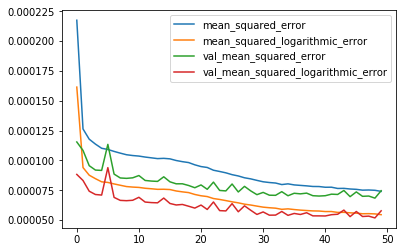

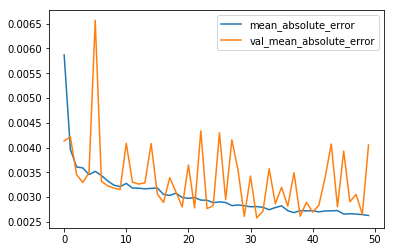

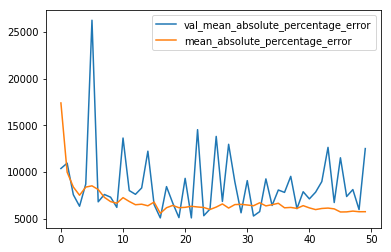

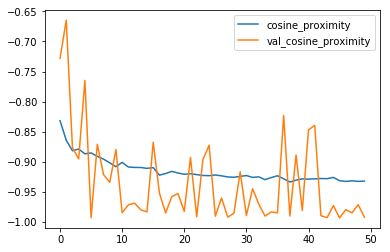

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 12s - loss: 0.0066 - mean_squared_error: 2.4820e-04 - mean_absolute_error: 0.0066 - mean_absolute_percentage_error: 21268.7253 - cosine_proximity: -8.1560e-01 - mean_squared_logarithmic_error: 1.8632e-04 - val_loss: 0.0040 - val_mean_squared_error: 1.1759e-04 - val_mean_absolute_error: 0.0040 - val_mean_absolute_percentage_error: 8185.5698 - val_cosine_proximity: -8.7955e-01 - val_mean_squared_logarithmic_error: 9.0754e-05
Epoch 2/50
 - 9s - loss: 0.0039 - mean_squared_error: 1.2560e-04 - mean_absolute_error: 0.0039 - mean_absolute_percentage_error: 9360.0657 - cosine_proximity: -8.6669e-01 - mean_squared_logarithmic_error: 9.3562e-05 - val_loss: 0.0050 - val_mean_squared_error: 1.1658e-04 - val_mean_absolute_error: 0.0050 - val_mean_absolute_percentage_error: 15408.8424 - val_cosine_proximity: -9.9271e-01 - val_mean_squared_logarithmic_error: 9.1721e-05
Epoch 3/50
 - 8s - loss: 0.0035 - mean_squared_error: 1.1722e-04 - me

Epoch 20/50
 - 6s - loss: 0.0030 - mean_squared_error: 9.7061e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 5908.8624 - cosine_proximity: -9.2165e-01 - mean_squared_logarithmic_error: 7.2196e-05 - val_loss: 0.0036 - val_mean_squared_error: 8.3289e-05 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 8188.5639 - val_cosine_proximity: -7.4126e-01 - val_mean_squared_logarithmic_error: 6.5523e-05
Epoch 21/50
 - 6s - loss: 0.0030 - mean_squared_error: 9.7040e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6152.3629 - cosine_proximity: -9.1631e-01 - mean_squared_logarithmic_error: 7.2097e-05 - val_loss: 0.0050 - val_mean_squared_error: 9.0578e-05 - val_mean_absolute_error: 0.0050 - val_mean_absolute_percentage_error: 17943.2074 - val_cosine_proximity: -9.9343e-01 - val_mean_squared_logarithmic_error: 7.3193e-05
Epoch 22/50
 - 7s - loss: 0.0030 - mean_squared_error: 9.5838e-05 - mean_absolute_error: 0.0030 - mean_absolute_percent

Epoch 39/50
 - 7s - loss: 0.0027 - mean_squared_error: 8.4469e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6526.9367 - cosine_proximity: -9.2762e-01 - mean_squared_logarithmic_error: 6.1857e-05 - val_loss: 0.0028 - val_mean_squared_error: 6.5250e-05 - val_mean_absolute_error: 0.0028 - val_mean_absolute_percentage_error: 7903.3671 - val_cosine_proximity: -9.6800e-01 - val_mean_squared_logarithmic_error: 5.1190e-05
Epoch 40/50
 - 7s - loss: 0.0027 - mean_squared_error: 8.3670e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6581.3427 - cosine_proximity: -9.2738e-01 - mean_squared_logarithmic_error: 6.1265e-05 - val_loss: 0.0030 - val_mean_squared_error: 6.7529e-05 - val_mean_absolute_error: 0.0030 - val_mean_absolute_percentage_error: 8363.5995 - val_cosine_proximity: -9.7600e-01 - val_mean_squared_logarithmic_error: 5.2914e-05
Epoch 41/50
 - 7s - loss: 0.0027 - mean_squared_error: 8.3554e-05 - mean_absolute_error: 0.0027 - mean_absolute_percenta

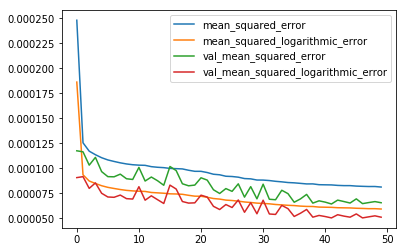

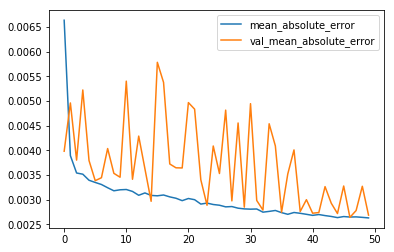

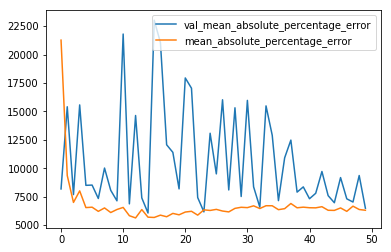

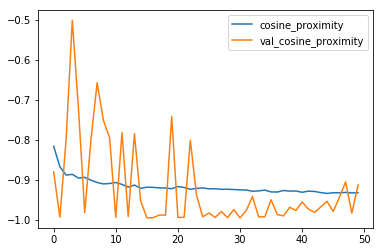

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 8s - loss: 0.0059 - mean_squared_error: 2.2605e-04 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 17676.1888 - cosine_proximity: -8.3804e-01 - mean_squared_logarithmic_error: 1.5729e-04 - val_loss: 0.0056 - val_mean_squared_error: 1.2481e-04 - val_mean_absolute_error: 0.0056 - val_mean_absolute_percentage_error: 18279.1597 - val_cosine_proximity: -4.7240e-01 - val_mean_squared_logarithmic_error: 9.7664e-05
Epoch 2/50
 - 7s - loss: 0.0038 - mean_squared_error: 1.2869e-04 - mean_absolute_error: 0.0038 - mean_absolute_percentage_error: 8950.1448 - cosine_proximity: -8.7634e-01 - mean_squared_logarithmic_error: 9.4253e-05 - val_loss: 0.0034 - val_mean_squared_error: 1.0125e-04 - val_mean_absolute_error: 0.0034 - val_mean_absolute_percentage_error: 7042.4873 - val_cosine_proximity: -8.7012e-01 - val_mean_squared_logarithmic_error: 8.0195e-05
Epoch 3/50
 - 7s - loss: 0.0035 - mean_squared_error: 1.1945e-04 - mea

Epoch 20/50
 - 8s - loss: 0.0029 - mean_squared_error: 9.3021e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 5775.7122 - cosine_proximity: -9.2562e-01 - mean_squared_logarithmic_error: 6.8368e-05 - val_loss: 0.0031 - val_mean_squared_error: 7.5370e-05 - val_mean_absolute_error: 0.0031 - val_mean_absolute_percentage_error: 7040.3480 - val_cosine_proximity: -8.3895e-01 - val_mean_squared_logarithmic_error: 6.0205e-05
Epoch 21/50
 - 9s - loss: 0.0030 - mean_squared_error: 9.2630e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6409.3086 - cosine_proximity: -9.1443e-01 - mean_squared_logarithmic_error: 6.8171e-05 - val_loss: 0.0036 - val_mean_squared_error: 7.8754e-05 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 9261.4521 - val_cosine_proximity: -7.1558e-01 - val_mean_squared_logarithmic_error: 6.3032e-05
Epoch 22/50
 - 7s - loss: 0.0029 - mean_squared_error: 9.1722e-05 - mean_absolute_error: 0.0029 - mean_absolute_percenta

Epoch 39/50
 - 7s - loss: 0.0027 - mean_squared_error: 8.3015e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6496.6584 - cosine_proximity: -9.2982e-01 - mean_squared_logarithmic_error: 6.0582e-05 - val_loss: 0.0031 - val_mean_squared_error: 6.8219e-05 - val_mean_absolute_error: 0.0031 - val_mean_absolute_percentage_error: 7916.0216 - val_cosine_proximity: -8.0561e-01 - val_mean_squared_logarithmic_error: 5.4565e-05
Epoch 40/50
 - 7s - loss: 0.0027 - mean_squared_error: 8.2936e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6587.5530 - cosine_proximity: -9.2594e-01 - mean_squared_logarithmic_error: 6.0491e-05 - val_loss: 0.0027 - val_mean_squared_error: 6.5585e-05 - val_mean_absolute_error: 0.0027 - val_mean_absolute_percentage_error: 6399.3518 - val_cosine_proximity: -9.1578e-01 - val_mean_squared_logarithmic_error: 5.2326e-05
Epoch 41/50
 - 7s - loss: 0.0027 - mean_squared_error: 8.2352e-05 - mean_absolute_error: 0.0027 - mean_absolute_percenta

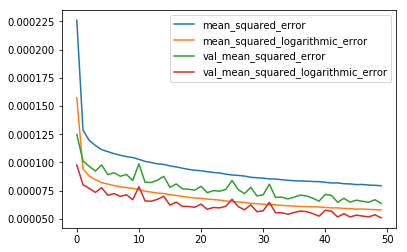

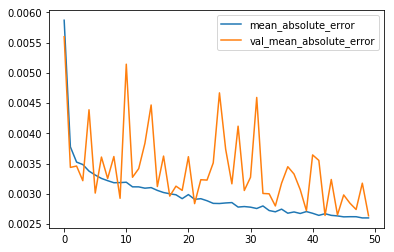

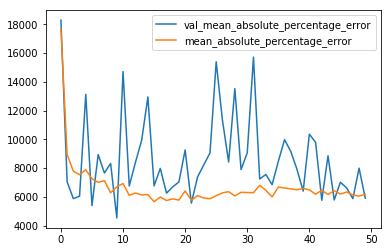

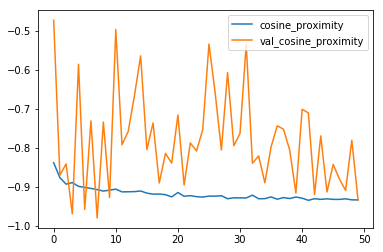

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 9s - loss: 0.0065 - mean_squared_error: 2.5498e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 26581.2668 - cosine_proximity: -8.2049e-01 - mean_squared_logarithmic_error: 1.8098e-04 - val_loss: 0.0062 - val_mean_squared_error: 1.4932e-04 - val_mean_absolute_error: 0.0062 - val_mean_absolute_percentage_error: 18691.7448 - val_cosine_proximity: -9.9271e-01 - val_mean_squared_logarithmic_error: 1.1572e-04
Epoch 2/50
 - 8s - loss: 0.0039 - mean_squared_error: 1.2687e-04 - mean_absolute_error: 0.0039 - mean_absolute_percentage_error: 10574.7069 - cosine_proximity: -8.6835e-01 - mean_squared_logarithmic_error: 9.5449e-05 - val_loss: 0.0045 - val_mean_squared_error: 1.2088e-04 - val_mean_absolute_error: 0.0045 - val_mean_absolute_percentage_error: 11246.2239 - val_cosine_proximity: -9.7346e-01 - val_mean_squared_logarithmic_error: 9.2457e-05
Epoch 3/50
 - 8s - loss: 0.0037 - mean_squared_error: 1.1721e-04 - m

Epoch 20/50
 - 6s - loss: 0.0030 - mean_squared_error: 9.2519e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6568.2475 - cosine_proximity: -9.2063e-01 - mean_squared_logarithmic_error: 6.9228e-05 - val_loss: 0.0031 - val_mean_squared_error: 8.8687e-05 - val_mean_absolute_error: 0.0031 - val_mean_absolute_percentage_error: 6524.7479 - val_cosine_proximity: -9.6372e-01 - val_mean_squared_logarithmic_error: 6.7724e-05
Epoch 21/50
 - 7s - loss: 0.0030 - mean_squared_error: 9.1899e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6451.5545 - cosine_proximity: -9.2016e-01 - mean_squared_logarithmic_error: 6.8756e-05 - val_loss: 0.0037 - val_mean_squared_error: 9.3379e-05 - val_mean_absolute_error: 0.0037 - val_mean_absolute_percentage_error: 7285.5350 - val_cosine_proximity: -7.4415e-01 - val_mean_squared_logarithmic_error: 7.1502e-05
Epoch 22/50
 - 7s - loss: 0.0029 - mean_squared_error: 9.1189e-05 - mean_absolute_error: 0.0029 - mean_absolute_percenta

Epoch 39/50
 - 8s - loss: 0.0028 - mean_squared_error: 7.9548e-05 - mean_absolute_error: 0.0028 - mean_absolute_percentage_error: 7399.4103 - cosine_proximity: -9.2177e-01 - mean_squared_logarithmic_error: 5.8908e-05 - val_loss: 0.0027 - val_mean_squared_error: 7.5232e-05 - val_mean_absolute_error: 0.0027 - val_mean_absolute_percentage_error: 5109.7444 - val_cosine_proximity: -9.4616e-01 - val_mean_squared_logarithmic_error: 5.6059e-05
Epoch 40/50
 - 7s - loss: 0.0027 - mean_squared_error: 7.9307e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 7377.5170 - cosine_proximity: -9.2470e-01 - mean_squared_logarithmic_error: 5.8704e-05 - val_loss: 0.0029 - val_mean_squared_error: 7.6290e-05 - val_mean_absolute_error: 0.0029 - val_mean_absolute_percentage_error: 6243.8354 - val_cosine_proximity: -8.8658e-01 - val_mean_squared_logarithmic_error: 5.7001e-05
Epoch 41/50
 - 7s - loss: 0.0026 - mean_squared_error: 7.8448e-05 - mean_absolute_error: 0.0026 - mean_absolute_percenta

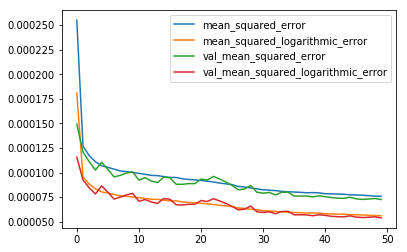

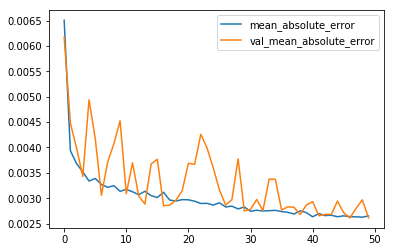

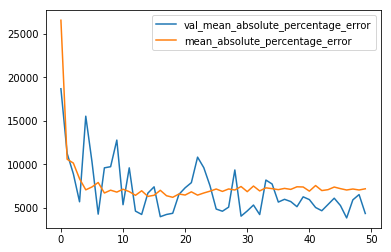

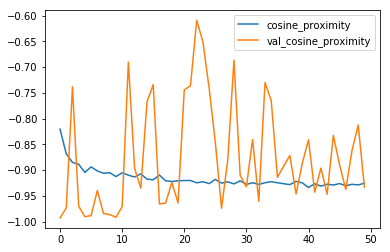

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 10s - loss: 0.0065 - mean_squared_error: 2.4896e-04 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 23638.4103 - cosine_proximity: -8.2735e-01 - mean_squared_logarithmic_error: 1.7829e-04 - val_loss: 0.0038 - val_mean_squared_error: 1.3109e-04 - val_mean_absolute_error: 0.0038 - val_mean_absolute_percentage_error: 7310.0067 - val_cosine_proximity: -7.9780e-01 - val_mean_squared_logarithmic_error: 9.8737e-05
Epoch 2/50
 - 8s - loss: 0.0037 - mean_squared_error: 1.1633e-04 - mean_absolute_error: 0.0037 - mean_absolute_percentage_error: 8351.1491 - cosine_proximity: -8.8656e-01 - mean_squared_logarithmic_error: 8.7137e-05 - val_loss: 0.0039 - val_mean_squared_error: 1.2187e-04 - val_mean_absolute_error: 0.0039 - val_mean_absolute_percentage_error: 8226.1579 - val_cosine_proximity: -7.3504e-01 - val_mean_squared_logarithmic_error: 9.2461e-05
Epoch 3/50
 - 7s - loss: 0.0035 - mean_squared_error: 1.0905e-04 - mea

Epoch 20/50
 - 6s - loss: 0.0030 - mean_squared_error: 8.8231e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6587.3908 - cosine_proximity: -9.2035e-01 - mean_squared_logarithmic_error: 6.5820e-05 - val_loss: 0.0035 - val_mean_squared_error: 9.4616e-05 - val_mean_absolute_error: 0.0035 - val_mean_absolute_percentage_error: 9393.6967 - val_cosine_proximity: -7.3366e-01 - val_mean_squared_logarithmic_error: 7.3413e-05
Epoch 21/50
 - 6s - loss: 0.0029 - mean_squared_error: 8.7005e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 6479.9721 - cosine_proximity: -9.2136e-01 - mean_squared_logarithmic_error: 6.4873e-05 - val_loss: 0.0029 - val_mean_squared_error: 8.9268e-05 - val_mean_absolute_error: 0.0029 - val_mean_absolute_percentage_error: 6201.9108 - val_cosine_proximity: -9.1346e-01 - val_mean_squared_logarithmic_error: 6.9031e-05
Epoch 22/50
 - 6s - loss: 0.0029 - mean_squared_error: 8.6526e-05 - mean_absolute_error: 0.0029 - mean_absolute_percenta

Epoch 39/50
 - 7s - loss: 0.0026 - mean_squared_error: 7.4631e-05 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 6099.5092 - cosine_proximity: -9.3272e-01 - mean_squared_logarithmic_error: 5.4973e-05 - val_loss: 0.0030 - val_mean_squared_error: 7.8642e-05 - val_mean_absolute_error: 0.0030 - val_mean_absolute_percentage_error: 8346.1316 - val_cosine_proximity: -8.2017e-01 - val_mean_squared_logarithmic_error: 6.0902e-05
Epoch 40/50
 - 7s - loss: 0.0026 - mean_squared_error: 7.4199e-05 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 5887.9732 - cosine_proximity: -9.3414e-01 - mean_squared_logarithmic_error: 5.4642e-05 - val_loss: 0.0033 - val_mean_squared_error: 7.9819e-05 - val_mean_absolute_error: 0.0033 - val_mean_absolute_percentage_error: 10159.2742 - val_cosine_proximity: -7.3147e-01 - val_mean_squared_logarithmic_error: 6.1902e-05
Epoch 41/50
 - 7s - loss: 0.0026 - mean_squared_error: 7.4059e-05 - mean_absolute_error: 0.0026 - mean_absolute_percent

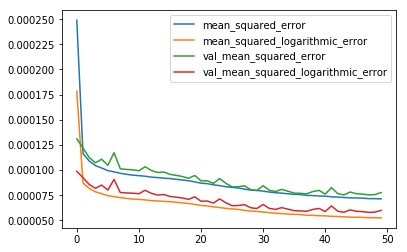

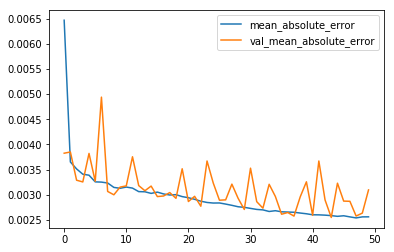

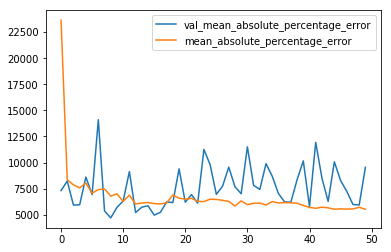

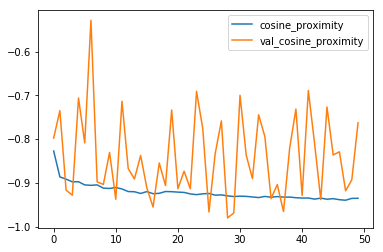

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 11s - loss: 0.0064 - mean_squared_error: 2.4121e-04 - mean_absolute_error: 0.0064 - mean_absolute_percentage_error: 23719.4542 - cosine_proximity: -8.2798e-01 - mean_squared_logarithmic_error: 1.8017e-04 - val_loss: 0.0058 - val_mean_squared_error: 1.5180e-04 - val_mean_absolute_error: 0.0058 - val_mean_absolute_percentage_error: 21421.2503 - val_cosine_proximity: -4.4487e-01 - val_mean_squared_logarithmic_error: 1.0964e-04
Epoch 2/50
 - 8s - loss: 0.0038 - mean_squared_error: 1.2077e-04 - mean_absolute_error: 0.0038 - mean_absolute_percentage_error: 9017.3630 - cosine_proximity: -8.7464e-01 - mean_squared_logarithmic_error: 9.1639e-05 - val_loss: 0.0053 - val_mean_squared_error: 1.3369e-04 - val_mean_absolute_error: 0.0053 - val_mean_absolute_percentage_error: 17812.4324 - val_cosine_proximity: -5.0228e-01 - val_mean_squared_logarithmic_error: 9.8267e-05
Epoch 3/50
 - 8s - loss: 0.0036 - mean_squared_error: 1.1214e-04 - m

Epoch 20/50
 - 8s - loss: 0.0030 - mean_squared_error: 9.0907e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6290.9403 - cosine_proximity: -9.1723e-01 - mean_squared_logarithmic_error: 6.9570e-05 - val_loss: 0.0032 - val_mean_squared_error: 9.1886e-05 - val_mean_absolute_error: 0.0032 - val_mean_absolute_percentage_error: 7748.6908 - val_cosine_proximity: -7.9895e-01 - val_mean_squared_logarithmic_error: 6.7877e-05
Epoch 21/50
 - 9s - loss: 0.0029 - mean_squared_error: 9.0116e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 5884.1205 - cosine_proximity: -9.2543e-01 - mean_squared_logarithmic_error: 6.8941e-05 - val_loss: 0.0039 - val_mean_squared_error: 9.5279e-05 - val_mean_absolute_error: 0.0039 - val_mean_absolute_percentage_error: 11800.6975 - val_cosine_proximity: -6.7693e-01 - val_mean_squared_logarithmic_error: 7.0821e-05
Epoch 22/50
 - 9s - loss: 0.0029 - mean_squared_error: 8.9346e-05 - mean_absolute_error: 0.0029 - mean_absolute_percent

Epoch 39/50
 - 6s - loss: 0.0027 - mean_squared_error: 7.8277e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6089.6195 - cosine_proximity: -9.2755e-01 - mean_squared_logarithmic_error: 5.9512e-05 - val_loss: 0.0031 - val_mean_squared_error: 8.1281e-05 - val_mean_absolute_error: 0.0031 - val_mean_absolute_percentage_error: 8780.1271 - val_cosine_proximity: -7.7397e-01 - val_mean_squared_logarithmic_error: 5.9279e-05
Epoch 40/50
 - 6s - loss: 0.0027 - mean_squared_error: 7.7929e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 6228.0556 - cosine_proximity: -9.2609e-01 - mean_squared_logarithmic_error: 5.9272e-05 - val_loss: 0.0030 - val_mean_squared_error: 8.0233e-05 - val_mean_absolute_error: 0.0030 - val_mean_absolute_percentage_error: 8490.5542 - val_cosine_proximity: -7.8333e-01 - val_mean_squared_logarithmic_error: 5.8562e-05
Epoch 41/50
 - 6s - loss: 0.0027 - mean_squared_error: 7.7066e-05 - mean_absolute_error: 0.0027 - mean_absolute_percenta

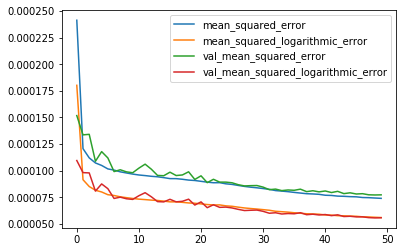

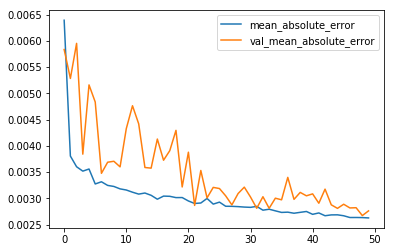

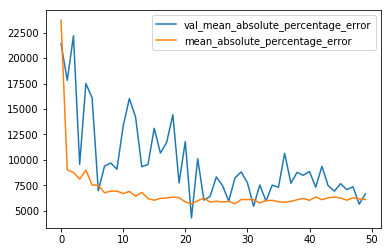

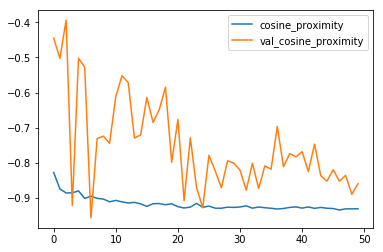

Train on 51267 samples, validate on 25252 samples
Epoch 1/50
 - 9s - loss: 0.0060 - mean_squared_error: 1.9078e-04 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 18504.1769 - cosine_proximity: -8.1411e-01 - mean_squared_logarithmic_error: 1.4797e-04 - val_loss: 0.0036 - val_mean_squared_error: 1.2900e-04 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 7208.7584 - val_cosine_proximity: -9.1012e-01 - val_mean_squared_logarithmic_error: 9.3404e-05
Epoch 2/50
 - 8s - loss: 0.0037 - mean_squared_error: 1.1324e-04 - mean_absolute_error: 0.0037 - mean_absolute_percentage_error: 8056.1461 - cosine_proximity: -8.7782e-01 - mean_squared_logarithmic_error: 8.6652e-05 - val_loss: 0.0034 - val_mean_squared_error: 1.1928e-04 - val_mean_absolute_error: 0.0034 - val_mean_absolute_percentage_error: 7524.6601 - val_cosine_proximity: -9.4895e-01 - val_mean_squared_logarithmic_error: 8.6915e-05
Epoch 3/50
 - 8s - loss: 0.0036 - mean_squared_error: 1.0694e-04 - mean

Epoch 20/50
 - 7s - loss: 0.0030 - mean_squared_error: 8.4430e-05 - mean_absolute_error: 0.0030 - mean_absolute_percentage_error: 6402.9305 - cosine_proximity: -9.1741e-01 - mean_squared_logarithmic_error: 6.4623e-05 - val_loss: 0.0032 - val_mean_squared_error: 9.3010e-05 - val_mean_absolute_error: 0.0032 - val_mean_absolute_percentage_error: 9453.8302 - val_cosine_proximity: -9.8119e-01 - val_mean_squared_logarithmic_error: 6.8140e-05
Epoch 21/50
 - 7s - loss: 0.0029 - mean_squared_error: 8.3176e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 6022.4640 - cosine_proximity: -9.2388e-01 - mean_squared_logarithmic_error: 6.3597e-05 - val_loss: 0.0032 - val_mean_squared_error: 9.3015e-05 - val_mean_absolute_error: 0.0032 - val_mean_absolute_percentage_error: 9569.5459 - val_cosine_proximity: -9.7973e-01 - val_mean_squared_logarithmic_error: 6.8136e-05
Epoch 22/50
 - 7s - loss: 0.0029 - mean_squared_error: 8.2520e-05 - mean_absolute_error: 0.0029 - mean_absolute_percenta

Epoch 39/50
 - 7s - loss: 0.0026 - mean_squared_error: 7.1942e-05 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 5856.4264 - cosine_proximity: -9.3255e-01 - mean_squared_logarithmic_error: 5.4718e-05 - val_loss: 0.0027 - val_mean_squared_error: 8.2221e-05 - val_mean_absolute_error: 0.0027 - val_mean_absolute_percentage_error: 7773.1227 - val_cosine_proximity: -9.5591e-01 - val_mean_squared_logarithmic_error: 5.9431e-05
Epoch 40/50
 - 7s - loss: 0.0027 - mean_squared_error: 7.1623e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 5867.9747 - cosine_proximity: -9.3129e-01 - mean_squared_logarithmic_error: 5.4483e-05 - val_loss: 0.0027 - val_mean_squared_error: 8.2053e-05 - val_mean_absolute_error: 0.0027 - val_mean_absolute_percentage_error: 7992.6735 - val_cosine_proximity: -9.4777e-01 - val_mean_squared_logarithmic_error: 5.9359e-05
Epoch 41/50
 - 8s - loss: 0.0027 - mean_squared_error: 7.1336e-05 - mean_absolute_error: 0.0027 - mean_absolute_percenta

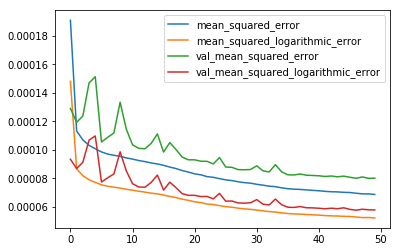

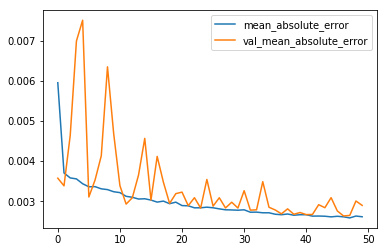

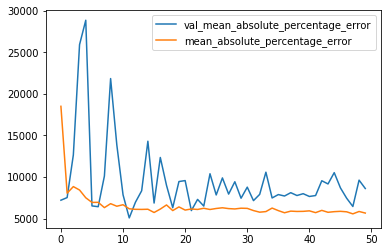

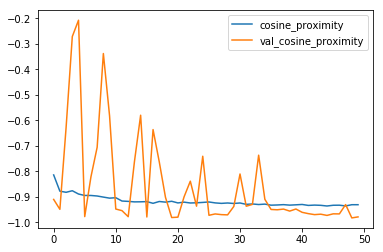

loss
0.00306753% (+/- 0.00045737%)
mean_squared_error
0.00007428% (+/- 0.00000712%)
mean_absolute_error
0.00306753% (+/- 0.00045737%)
mean_absolute_percentage_error
8126.20138976% (+/- 2321.49635292%)
cosine_proximity
-0.93376398% (+/- 0.07038034%)
mean_squared_logarithmic_error
0.00005556% (+/- 0.00000397%)


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

cvscores = []
cvscorenames = []
histories_1=[]
for seed in range(10):
    train_X_split, test_X_split, train_y_split, test_y_split = train_test_split(reframed.values[:, :-1], reframed.values[:, -1], test_size=0.33, random_state=seed)
    
    train_X_split, test_X_split = train_X_split.reshape(train_X_split.shape[0],1,train_X_split.shape[1]), test_X_split.reshape(test_X_split.shape[0],1,test_X_split.shape[1])

    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X_split.shape[1], train_X_split.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine', 'msle'])
    # fit network
    history = model.fit(train_X_split, train_y_split, epochs=50, batch_size=72, validation_data=(test_X_split, test_y_split), verbose=2, shuffle=False)
    # plot history
    #pyplot.figure(figsize=(15,20))
    
    #pyplot.plot(history.history['loss'], label='loss')
    #pyplot.plot(history.history['val_loss'], label='val_loss')
    #pyplot.legend()
    #pyplot.show()
    
    pyplot.plot(history.history['mean_squared_error'], label='mean_squared_error')
    pyplot.plot(history.history['mean_squared_logarithmic_error'], label='mean_squared_logarithmic_error')
    pyplot.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
    pyplot.plot(history.history['val_mean_squared_logarithmic_error'], label='val_mean_squared_logarithmic_error')
    pyplot.legend()
    pyplot.show()
    
    pyplot.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
    pyplot.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
    pyplot.legend()
    pyplot.show()
    
    pyplot.plot(history.history['val_mean_absolute_percentage_error'], label='val_mean_absolute_percentage_error')
    pyplot.plot(history.history['mean_absolute_percentage_error'], label='mean_absolute_percentage_error')
    pyplot.legend()
    pyplot.show()
    
    pyplot.plot(history.history['cosine_proximity'], label='cosine_proximity')
    pyplot.plot(history.history['val_cosine_proximity'], label='val_cosine_proximity')
    pyplot.legend()
    pyplot.show()
    
    scores = model.evaluate(test_X_split, test_y_split, verbose=0)
    cvscorenames.append(model.metrics_names)
    cvscores.append(scores)
    histories_1.append(history)
i=0
for score in np.array(cvscores).T:
    print(cvscorenames[0][i])
    print("%.8f%% (+/- %.8f%%)" % (np.mean(score), np.std(score)))
    i=i+1

['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'mean_squared_logarithmic_error']
   loss  mean_squared_error  mean_absolute_error  \
0 0.003               0.000                0.003   
1 0.003               0.000                0.003   
2 0.004               0.000                0.004   
3 0.003               0.000                0.003   
4 0.003               0.000                0.003   
5 0.003               0.000                0.003   
6 0.003               0.000                0.003   
7 0.003               0.000                0.003   
8 0.003               0.000                0.003   
9 0.003               0.000                0.003   

   mean_absolute_percentage_error  cosine_proximity  \
0                        3713.663            -0.899   
1                        4217.619            -0.910   
2                       13291.296            -0.990   
3                        4459.590            -0.873   
4                 

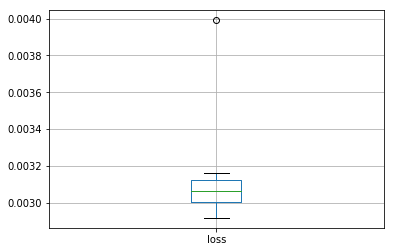

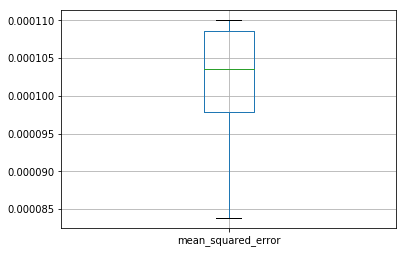

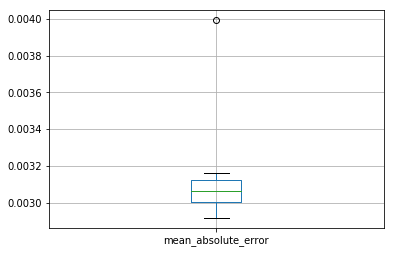

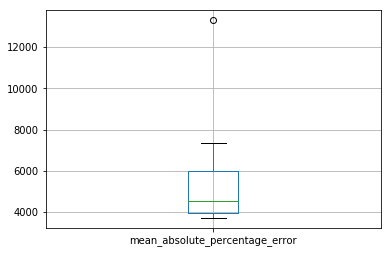

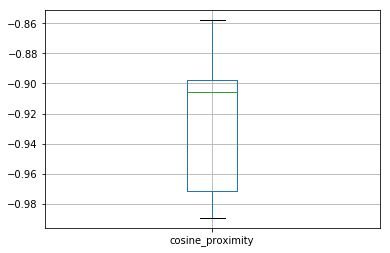

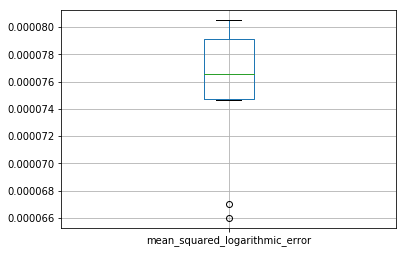

IndexError: list index out of range

In [60]:
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
np.set_printoptions(suppress=True)
print(cvscorenames[0][1:]) #, columns=[cvscorenames[0][:]]
cvscores_1=DataFrame(cvscores, columns=cvscorenames[0][:])
print(cvscores_1)
for index in range(len(cvscores)):
    cvscores_0=cvscores_1[[cvscorenames[0][index]]]
    cvscores_0.boxplot()
    pyplot.show()

In [7]:
import pickle as pkl
model.save_weights("sku_model.h5")
pkl.dump({"loss":history.history['loss'], "val_loss":history.history['val_loss']}, open( "sku_history.pkl", "wb" ))

[0.01251739] [0.01251739]
range(0, 25)
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24]
(62039, 1, 23)
(15509, 1, 23)
Train on 62039 samples, validate on 15509 samples
Epoch 1/50
 - 10s - loss: 0.0097 - val_loss: 0.0123
Epoch 2/50
 - 9s - loss: 0.0063 - val_loss: 0.0084
Epoch 3/50
 - 9s - loss: 0.0044 - val_loss: 0.0055
Epoch 4/50
 - 8s - loss: 0.0040 - val_loss: 0.0050
Epoch 5/50
 - 8s - loss: 0.0034 - val_loss: 0.0062
Epoch 6/50
 - 9s - loss: 0.0035 - val_loss: 0.0043
Epoch 7/50
 - 8s - loss: 0.0037 - val_loss: 0.0042
Epoch 8/50
 - 9s - loss: 0.0034 - val_loss: 0.0049
Epoch 9/50
 - 9s - loss: 0.0033 - val_loss: 0.0040
Epoch 10/50
 - 9s - loss: 0.0035 - val_loss: 0.0039
Epoch 11/50
 - 8s - loss: 0.0033 - val_loss: 0.0039
Epoch 12/50
 - 9s - loss: 0.0036 - val_loss: 0.0047
Epoch 13/50
 - 9s - loss: 0.0033 - val_loss: 0.0046
Epoch 14/50
 - 8s - loss: 0.0032 - val_loss: 0.0045
Epoch 15/50
 - 8s - loss: 0.0032 - val_loss: 0.0039
Epoch 16/50
 - 8s - loss: 0.0031 - val

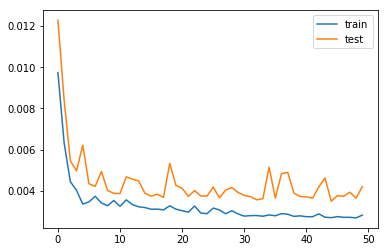

In [290]:
import numpy as np

sku_column,  = np.where(df.columns == 'SKU')
cat_columns = range(train_X.shape[2])
print(train_X[1000,0,sku_column], train_X[1000,0,sku_column+len(df.columns)-1])
print(cat_columns)
cat_columns = np.setdiff1d(cat_columns,[sku_column,sku_column+len(df.columns)-1])
print(cat_columns)
cat_train_X=train_X[:,0,cat_columns]
cat_train_X = cat_train_X.reshape((cat_train_X.shape[0],1, cat_train_X.shape[1]))
print(cat_train_X.shape)
cat_test_X=test_X[:,0,cat_columns]
cat_test_X = cat_test_X.reshape((cat_test_X.shape[0],1, cat_test_X.shape[1]))
print(cat_test_X.shape)

# design network
cat_model = Sequential()
cat_model.add(LSTM(50, input_shape=(cat_train_X.shape[1], cat_train_X.shape[2])))
cat_model.add(Dense(1))
cat_model.compile(loss='mae', optimizer='adam')
# fit network
cat_history = cat_model.fit(cat_train_X, train_y, epochs=50, batch_size=72, validation_data=(cat_test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(cat_history.history['loss'], label='train')
pyplot.plot(cat_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Predict All

In [8]:
# make a prediction
yhat = model.predict(test_X)
test_X_ = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(yhat.shape, test_X_.shape)
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_[:,13:25]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
print(inv_yhat[0])
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_ = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_, test_X_[:,13:25]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
#np.set_printoptions(edgeitems=10)
#np.core.arrayprint._line_width = 180
print(inv_y[0])
inv_y = inv_y[:,0]
print(inv_y[0])
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_yhat[0], inv_y[0])
#print(scaler.inverse_transform(test_X_[0]))

(15509, 1) (15509, 25)
[3.26394115e+02 7.20000000e+01 1.24500000e+03 6.00000000e+00
 1.21400000e+01 1.45000000e+01 1.18100000e+01 9.98000000e+00
 1.14300000e+01 1.88600000e+01 2.64300000e+01 0.00000000e+00
 1.00000000e+00]
[2.810e+02 7.200e+01 1.245e+03 6.000e+00 1.214e+01 1.450e+01 1.181e+01
 9.980e+00 1.143e+01 1.886e+01 2.643e+01 0.000e+00 1.000e+00]
281.0
Test RMSE: 344.649
326.3941150829196 281.0


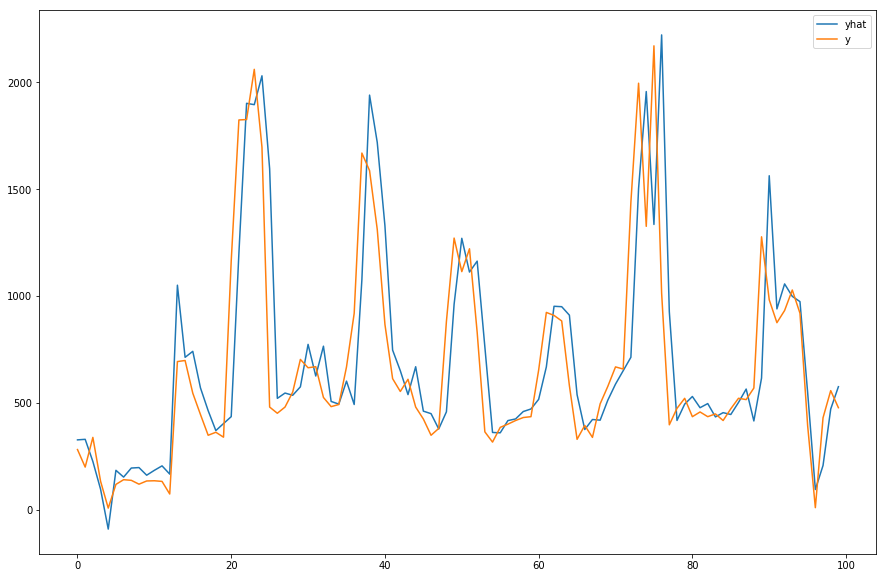

In [9]:
points_to_plot=100

pyplot.figure(figsize=(15,10))
pyplot.plot(range(len(inv_yhat[:points_to_plot])), inv_yhat[:points_to_plot], label='yhat')
pyplot.plot(range(len(inv_yhat[:points_to_plot])), inv_y[:points_to_plot], label='y')
pyplot.legend()
pyplot.show()

### Predict 1 from testing

In [10]:
test_X_new=np.array([test_X[0]])

yhat1 = model.predict(test_X_new)
test_X_new2 = test_X_new.reshape((test_X_new.shape[0], test_X_new.shape[2]))
print(yhat1.shape, test_X_new2[:,n_features:(2*n_features-1)].shape)
inv_yhat1 = concatenate((yhat1, test_X_new2[:,n_features:(2*n_features-1)]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)

#inv_yhat1 = inv_yhat1[:,0]
np.set_printoptions(suppress=True)
print(inv_yhat1)

(1, 1) (1, 12)
[[ 326.39399782   72.         1245.            6.           12.14
    14.5          11.81          9.98         11.43         18.86
    26.43          0.            1.        ]]


### Predict 1 from training

In [11]:
train_X_new=np.array([train_X[0]])

yhat1 = model.predict(train_X_new)
train_X_new2 = train_X_new.reshape((train_X_new.shape[0], train_X_new.shape[2]))
print(yhat1.shape, train_X_new2[:,13:25].shape)
inv_yhat1 = concatenate((yhat1, train_X_new2[:,13:25]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)

#inv_yhat1 = inv_yhat1[:,0]
np.set_printoptions(suppress=True)
print(inv_yhat1)

(1, 1) (1, 12)
[[220.96066973   1.         101.          30.          30.5
   32.55        27.94        30.5         17.29        22.71
   28.43         1.           0.        ]]


### Predict for 1 product

In [244]:
print(train_X.shape)
train_X_new=train_X[train_X[:,:,2]==0,:]
train_X_new=train_X_new.reshape(train_X_new.shape[0],1,train_X_new.shape[1])
print(train_X_new.shape)

yhat1 = model.predict(train_X_new)
train_X_new2 = train_X_new.reshape((train_X_new.shape[0], train_X_new.shape[2]))
print(yhat1.shape, train_X_new2[:,13:25].shape)
inv_yhat1 = concatenate((yhat1, train_X_new2[:,13:25]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)

train_y_new = train_y[train_X[:,0,2]==0]
train_y_new = train_y_new.reshape((len(train_y_new), 1))
inv_y1 = concatenate((train_y_new, train_X_new2[:,13:25]), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)

#np.set_printoptions(suppress=True)
#print(inv_yhat1)
#print(inv_y)

inv_yhat1 = inv_yhat1[:,0]
inv_y1 = inv_y1[:,0]

(62039, 1, 25)
(92, 1, 25)
(92, 1) (92, 12)


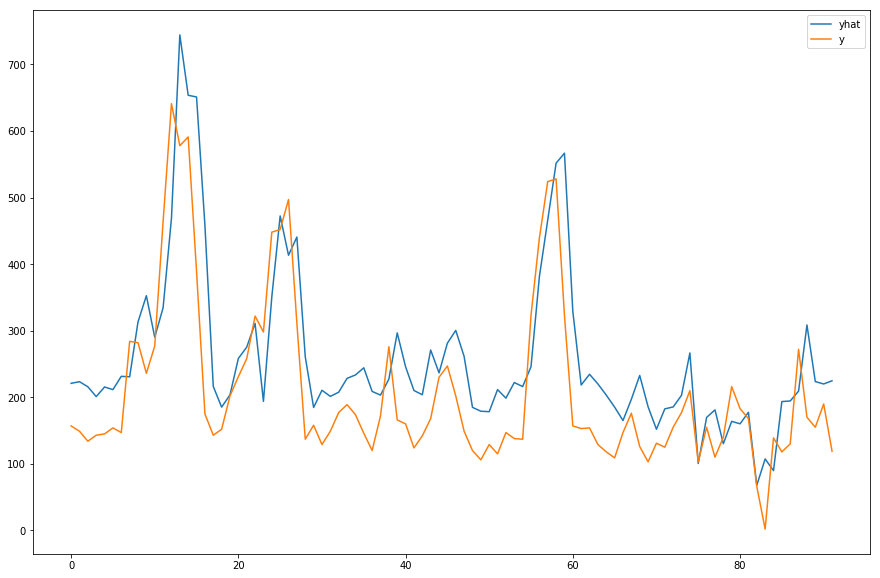

In [245]:
points_to_plot=100

pyplot.figure(figsize=(15,10))
pyplot.plot(range(len(inv_yhat1[:points_to_plot])), inv_yhat1[:points_to_plot], label='yhat')
pyplot.plot(range(len(inv_yhat1[:points_to_plot])), inv_y1[:points_to_plot], label='y')
pyplot.legend()
pyplot.show()

### Predict 1 product %10 price increase

In [246]:
print(train_X.shape)
train_X_new=train_X[train_X[:,:,2]==0,:]
train_X_new=train_X_new.reshape(train_X_new.shape[0],1,train_X_new.shape[1])
train_X_new[:,:,4]=2.1*train_X_new[:,:,4]
train_X_new[:,:,7]=2.1*train_X_new[:,:,7]
train_X_new[:,:,16]=2.1*train_X_new[:,:,16]
train_X_new[:,:,19]=2.1*train_X_new[:,:,19]
print(train_X_new.shape)

yhat1 = model.predict(train_X_new)
train_X_new2 = train_X_new.reshape((train_X_new.shape[0], train_X_new.shape[2]))
print(yhat1.shape, train_X_new2[:,13:25].shape)
inv_yhat1 = concatenate((yhat1, train_X_new2[:,13:25]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)

train_y_new = train_y[train_X[:,0,2]==0]
train_y_new = train_y_new.reshape((len(train_y_new), 1))
inv_y1 = concatenate((train_y_new, train_X_new2[:,13:25]), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)

#np.set_printoptions(suppress=True)
#print(inv_yhat1)
#print(inv_y)

inv_yhat1 = inv_yhat1[:,0]
inv_y1 = inv_y1[:,0]

(62039, 1, 25)
(92, 1, 25)
(92, 1) (92, 12)


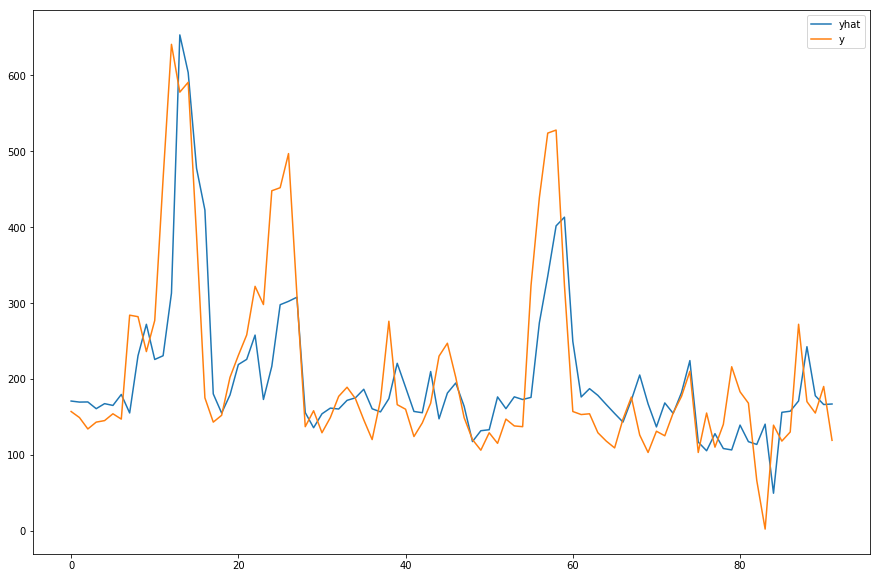

In [247]:
points_to_plot=100

pyplot.figure(figsize=(15,10))
pyplot.plot(range(len(inv_yhat1[:points_to_plot])), inv_yhat1[:points_to_plot], label='yhat')
pyplot.plot(range(len(inv_yhat1[:points_to_plot])), inv_y1[:points_to_plot], label='y')
pyplot.legend()
pyplot.show()

In [256]:

real_price_column,  = np.where(df.columns == 'REAL PRICE')
system_price_column,  = np.where(df.columns == 'SYSTEM PRICE')
competitors_price_column,  = np.where(df.columns == "Competitor's price")

def IncrementPrice(product_id=1, price_increment=1):
    product_id=np.unique(train_X[:,:,2])[product_id]
    #print(train_X.shape)
    train_X_new=train_X[train_X[:,:,2]==product_id,:]
    train_X_new=train_X_new.reshape(train_X_new.shape[0],1,train_X_new.shape[1])
    train_X_new[:,:,system_price_column]=price_increment*train_X_new[:,:,system_price_column]
    train_X_new[:,:,real_price_column]=price_increment*train_X_new[:,:,real_price_column]
    train_X_new[:,:,system_price_column+len(df.columns)-1]=price_increment*train_X_new[:,:,system_price_column+len(df.columns)-1]
    train_X_new[:,:,real_price_column+len(df.columns)-1]=price_increment*train_X_new[:,:,real_price_column+len(df.columns)-1]
    #print(train_X_new.shape)

    yhat1 = model.predict(train_X_new)
    train_X_new2 = train_X_new.reshape((train_X_new.shape[0], train_X_new.shape[2]))
    #print(yhat1.shape, train_X_new2[:,13:25].shape)
    inv_yhat1 = concatenate((yhat1, train_X_new2[:,13:25]), axis=1)
    inv_yhat1 = scaler.inverse_transform(inv_yhat1)

    train_y_new = train_y[train_X[:,0,2]==product_id]
    train_y_new = train_y_new.reshape((len(train_y_new), 1))
    inv_y1 = concatenate((train_y_new, train_X_new2[:,13:25]), axis=1)
    inv_y1 = scaler.inverse_transform(inv_y1)

    #np.set_printoptions(suppress=True)
    #print(inv_yhat1)
    #print(inv_y)
    #(1+(y[real_price_column]-y[competitors_price_column])/abs(y[competitors_price_column]) if y[competitors_price_column]!=0 else 0)**2
    return np.amax([np.sum(y[0]*y[real_price_column] for y in inv_yhat1),0]), inv_yhat1, inv_y1

gain, inv_yhat1, inv_y1 = IncrementPrice(3, 1)
print(inv_y1[0,:])

[507.     1.   105.    30.    20.5    0.    18.    20.5   17.29  22.71
  28.43   1.     0.  ]


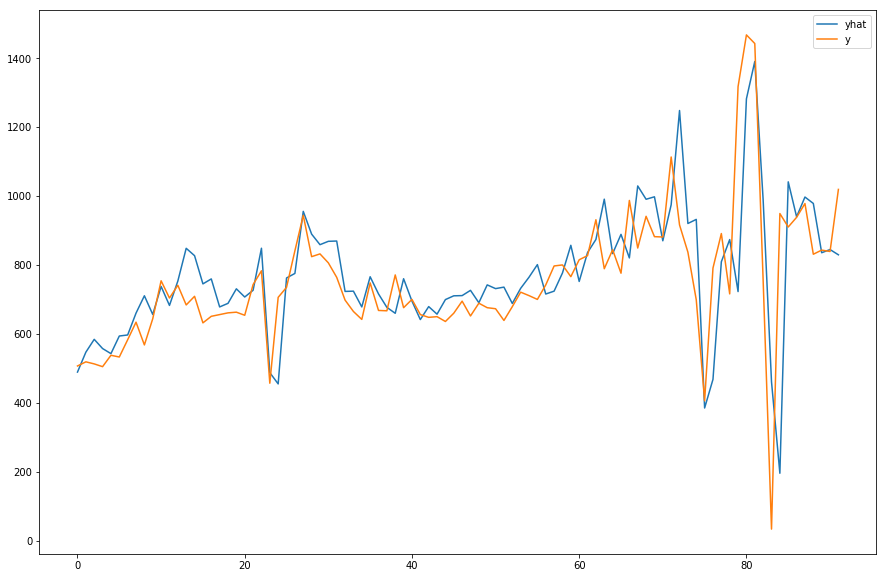

In [257]:
points_to_plot=100

pyplot.figure(figsize=(15,10))
pyplot.plot(range(len(inv_yhat1[:points_to_plot])), inv_yhat1[:points_to_plot,0], label='yhat')
pyplot.plot(range(len(inv_yhat1[:points_to_plot])), inv_y1[:points_to_plot,0], label='y')
pyplot.legend()
pyplot.show()

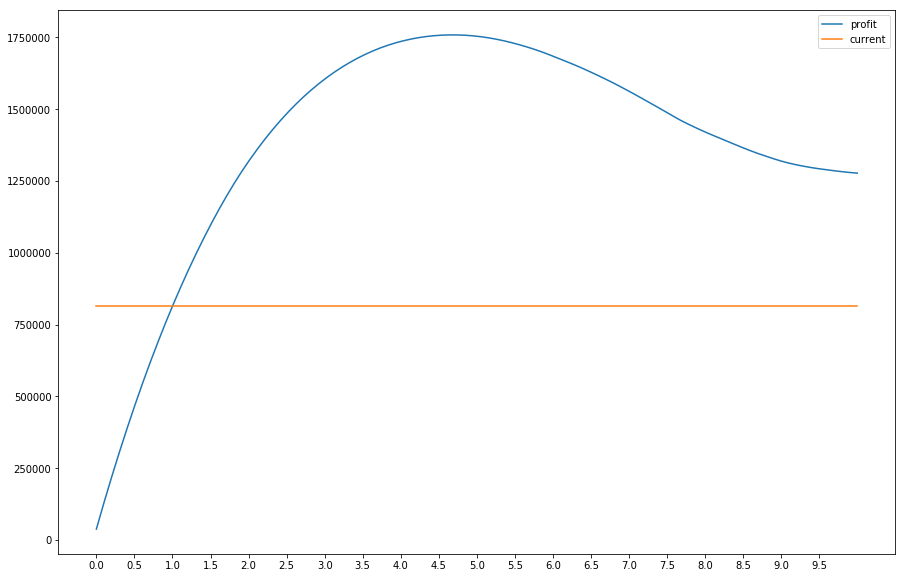

In [271]:
prod_id=1
increments = np.linspace(0, 10, 100, endpoint=True)
pyplot.figure(figsize=(15,10))
pyplot.xticks(np.arange(min(increments), max(increments), 0.5))
pyplot.plot(increments, [IncrementPrice(prod_id, inc)[0] for inc in increments], label='profit')
pyplot.plot(increments, [IncrementPrice(prod_id, 1)[0] for inc in increments], label='current')
pyplot.legend()
pyplot.show()

32


C:\Users\langh\Miniconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\langh\Miniconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\langh\Miniconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=353928.700649, expected=369020.000000
predicted=356132.326764, expected=349700.000000
predicted=354795.279269, expected=360756.000000
predicted=355632.229727, expected=354944.000000
predicted=356941.117946, expected=361632.000000
predicted=360292.261486, expected=358912.000000
predicted=360220.884737, expected=355102.000000
predicted=358054.108171, expected=347395.000000
predicted=355543.660502, expected=372339.000000
predicted=359837.237305, expected=360621.000000
predicted=362722.093772, expected=363251.000000
predicted=361504.237967, expected=370754.000000
predicted=363412.767508, expected=379260.000000
predicted=370035.035312, expected=382110.000000
predicted=375596.250817, expected=424434.000000
predicted=388942.400220, expected=254471.000000
predicted=362469.329673, expected=343073.000000
predicted=342779.719252, expected=375817.000000
predicted=359266.250905, expected=371890.000000
predicted=368634.437034, expected=376425.000000
predicted=358778.439816, expected=401031

C:\Users\langh\Miniconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=302060.313338, expected=426310.000000
predicted=294786.334905, expected=598637.000000
predicted=350000.649716, expected=461652.000000
predicted=288849.104134, expected=425786.000000
predicted=462162.095208, expected=411356.000000
predicted=409431.347940, expected=231171.000000
Test MSE: 13502308437.488


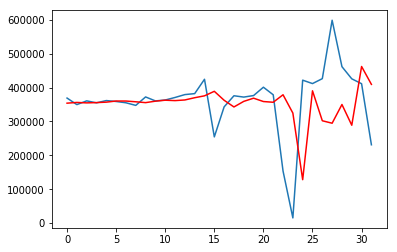

In [16]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

p = pd.DataFrame({'UNITS' : df.groupby(["date"])['UNITS'].sum()}).reset_index()
X = p.UNITS.values.astype('float64')
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
print(len(test))
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()